# Baseline

In [14]:
import kagglehub
import numpy as np
import pandas as pd 
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix 
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download dataset
base_path = kagglehub.dataset_download("chethuhn/network-intrusion-dataset")

files = [os.path.join(base_path, f) for f in os.listdir(base_path)]
print("Total files:", len(files))


Total files: 8


In [3]:
df_list = []

for file in files:
    print("Reading:", file)
    df = pd.read_csv(file)
    df_list.append(df)

full_df = pd.concat(df_list, ignore_index=True)

print("Final Shape:", full_df.shape)

Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Friday-WorkingHours-Morning.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Monday-WorkingHours.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Tuesday-WorkingHours.pcap_IS

In [4]:
full_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
print("Before cleaning:", full_df.shape)

# Remove duplicates
full_df.drop_duplicates(inplace=True)

# Replace infinity values with NaN
full_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop missing values
full_df.dropna(inplace=True)

print("After cleaning:", full_df.shape)

Before cleaning: (2830743, 79)
After cleaning: (2520798, 79)


In [6]:
full_df.columns = full_df.columns.str.strip()
print(full_df['Label'].value_counts())

Label
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [7]:
X = full_df.drop('Label', axis=1)
y = full_df['Label']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (2520798, 78)
Target shape: (2520798,)


In [8]:
# Encode categorical features with LabelEncoder (acceptable for tree models)
le = LabelEncoder()
full_df['Label'] = le.fit_transform(full_df['Label'])

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(full_df['Label'].value_counts())

Label
0     2095057
4      172846
2      128014
10      90694
3       10286
7        5931
6        5385
5        5228
11       3219
1        1948
12       1470
14        652
9          36
13         21
8          11
Name: count, dtype: int64


In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_scaled, y, stratify=y, test_size=0.1, random_state=42
)

In [11]:
os.makedirs('models', exist_ok=True)

total_trees = 200
step = 10

clf = RandomForestClassifier(n_estimators=step, warm_start=True, n_jobs=-1, random_state=42)
start = time.time()
for n in range(step, total_trees + 1, step):
    clf.set_params(n_estimators=n)
    clf.fit(X_train, y_train)
    elapsed = time.time() - start
    print(f"Trained {n}/{total_trees} trees ({n/total_trees*100:.1f}%), elapsed {elapsed:.1f}s")

Trained 10/200 trees (5.0%), elapsed 33.9s
Trained 20/200 trees (10.0%), elapsed 66.8s
Trained 30/200 trees (15.0%), elapsed 101.5s
Trained 40/200 trees (20.0%), elapsed 136.9s
Trained 50/200 trees (25.0%), elapsed 174.3s
Trained 60/200 trees (30.0%), elapsed 207.7s
Trained 70/200 trees (35.0%), elapsed 244.3s
Trained 80/200 trees (40.0%), elapsed 280.2s
Trained 90/200 trees (45.0%), elapsed 310.9s
Trained 100/200 trees (50.0%), elapsed 342.6s
Trained 110/200 trees (55.0%), elapsed 373.8s
Trained 120/200 trees (60.0%), elapsed 403.9s
Trained 130/200 trees (65.0%), elapsed 438.0s
Trained 140/200 trees (70.0%), elapsed 469.6s
Trained 150/200 trees (75.0%), elapsed 502.1s
Trained 160/200 trees (80.0%), elapsed 537.2s
Trained 170/200 trees (85.0%), elapsed 571.4s
Trained 180/200 trees (90.0%), elapsed 600.8s
Trained 190/200 trees (95.0%), elapsed 635.3s
Trained 200/200 trees (100.0%), elapsed 664.8s


Accuracy: 0.9987  Macro F1: 0.8890
Classification report:
                             precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    209506
                       Bot       0.90      0.72      0.80       195
                      DDoS       1.00      1.00      1.00     12801
             DoS GoldenEye       1.00      0.99      1.00      1029
                  DoS Hulk       1.00      1.00      1.00     17285
          DoS Slowhttptest       0.98      1.00      0.99       523
             DoS slowloris       1.00      0.99      0.99       538
               FTP-Patator       1.00      1.00      1.00       593
              Infiltration       1.00      1.00      1.00         4
                  PortScan       0.99      1.00      0.99      9069
               SSH-Patator       1.00      0.99      1.00       322
  Web Attack � Brute Force       0.72      0.95      0.82       147
Web Attack � Sql Injection       1.00      0.50      0.6

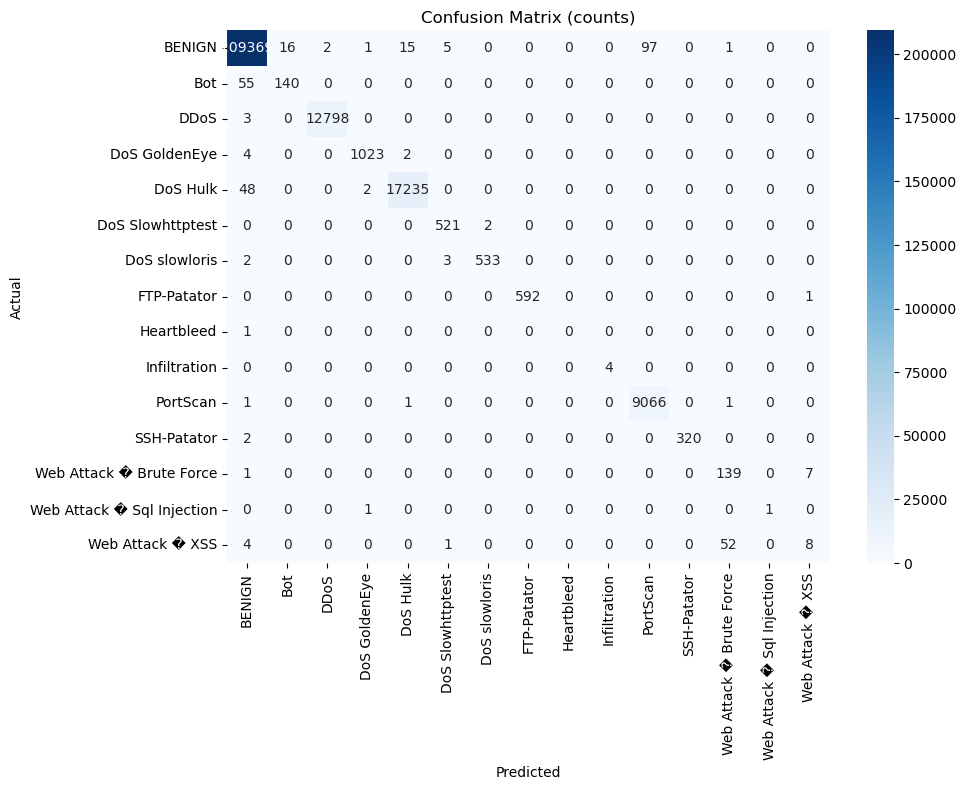

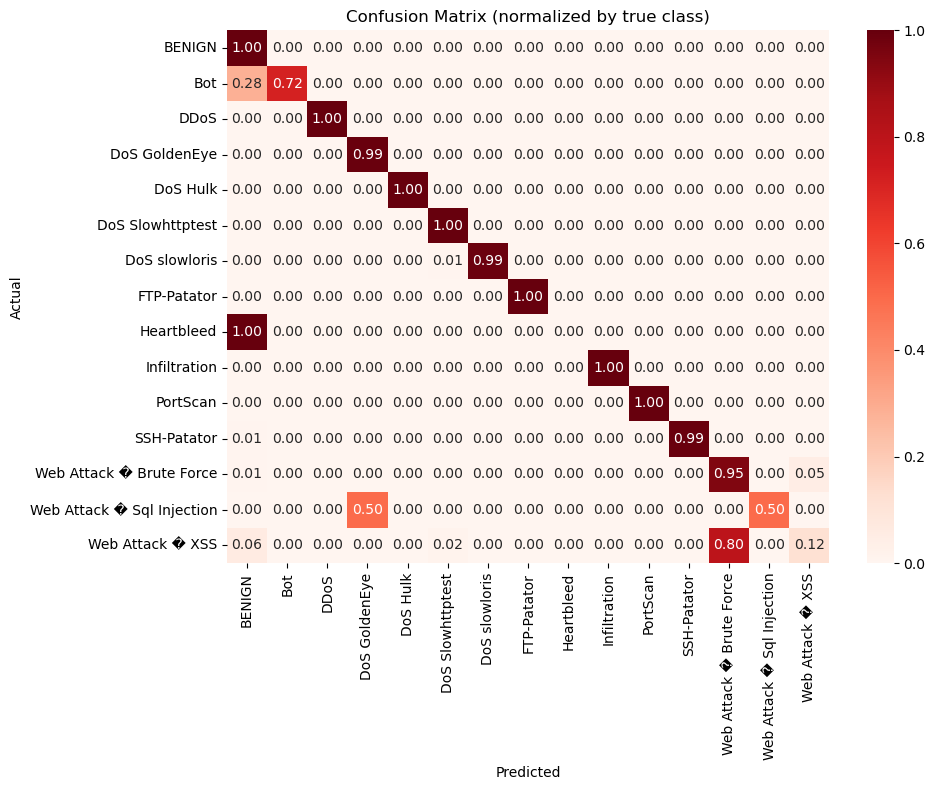

In [18]:
# Predictions & basic metrics
y_pred = clf.predict(X_valid)
print("Classification report:\n", classification_report(y_valid, y_pred, labels=np.unique(y_pred)))

# Confusion matrix (counts and normalized)
cm = confusion_matrix(y_valid, y_pred)
labels = np.unique(np.concatenate([y_valid, y_pred]).astype(str))

# Plot raw counts
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (counts)")
plt.tight_layout()
os.makedirs('models', exist_ok=True)
plt.show()

# Plot normalized (by true label / rows)
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-12)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (normalized by true class)")
plt.tight_layout()
plt.show()

In [17]:
# Save model + encoders
os.makedirs('models', exist_ok=True)
out_path = 'models/random_forest.joblib'
joblib.dump({
    'model': clf,
    'target_encoder': le
}, out_path)
print("Saved model to", out_path)

Saved model to baseline/models/random_forest.joblib
